In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic

import multiprocess

import os

In [49]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
orbit_path = '../orbits/keplerian_long.h5'
gw_path = 'gws.h5'

# Setup simluation parameters
fs = 0.1    # Hz
day = 86400 # s
duration = day*5 # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# Turn on/off binary creation & instrument simulation
use_verbinaries = True
# gen_new_gws = False
run_new_simulation = True

# Specify specific number of binaries
Ngalbins = 16

fs = 0.1 Hz,  orbit_duration = 1500.0 d


In [95]:
# Insert binary parameters
amplitude_amplification = 1e4

if use_verbinaries:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/MCMCsample'+str(int(duration))+'s'+'_verbins' #extention of .h5 or .txt added later
    
    rawdata = ascii.read("verbinaries_data_wsource_name.txt")
    
    params = ['lGal', 'bGal', 'orbital_period', 'm1', 'm1e', 'm2', 'm2e', 'i', 'freq', 'par','epar', 'dis', 'edis', 'A', 'eA', 'SNR', 'eSNR']
    # units: lGal [deg], bGal [deg], orbital_period [s], m1 [Msol], m1e [Msol], m2 [Msol], m2e [Msol]
    # i [deg], freq (of gws) [mHz], par [mas], epar [mas], dis [pc], edis [pc], A [1e-23], eA [1e-23], SNR, eSNR
    
    sourcenames = np.array(rawdata["source"])[:Ngalbins]
    Amp_true = (np.array(rawdata["A"])* (1e-23 * amplitude_amplification))[:Ngalbins] # 10yokto to 1e-23 
    f_true = (np.array(rawdata["freq"])* (1e-3))[:Ngalbins] # mHz to Hz
    iota = np.deg2rad(np.array(rawdata["i"]))[:Ngalbins] # deg to rad
    
    # Galactic coordinates of verification binaries   
    source_gal_lon = np.array(rawdata["lGal"])[:Ngalbins]  # degree range from [0,360]
    source_gal_lat = np.array(rawdata["bGal"])[:Ngalbins]  # degree range from [-90,90]

    # Transform coordinates to (barycentric mean) ecliptic coordinates
    gc = SkyCoord(l=source_gal_lon*u.degree, b=source_gal_lat*u.degree, frame='galactic')
    gw_beta_true = np.deg2rad(gc.barycentricmeanecliptic.lon.value)[:Ngalbins] # degree to rad range [0,2pi]
    gw_lambda_true = np.deg2rad(gc.barycentricmeanecliptic.lat.value)[:Ngalbins] # degree to rad range [-pi/2,pi/2]

    # Transform coordinates to equatoral (ICRS) coordinates
    # ra = gc.icrs.ra.value # degree range [0,360]
    # dec = gc.icrs.dec.value # degree range [-90,90]
    
    totNgalbins = len(sourcenames)
    phi0_true_forinst = np.zeros(Ngalbins)
    phi0_true = np.array(ascii.read("verbinaries_phaseoffset.txt")['phi0'])[:Ngalbins]
    print ("Number of Verification Binaries = {}".format(Ngalbins))

else:
    # Define name of simulation uitput file
    sample_outputf = 'measurements/MCMCsample'+str(int(duration))+'s' #extention of .h5 or .txt added later
    
    totNgalbins = 2
    Amp_true = np.array([1e-16,5e-13])[:Ngalbins]
    f_true = np.array([1e-3,1e-4])[:Ngalbins]
    
    phi0_true_forinst = np.zeros(Ngalbins)
    phi0_true = np.array([-0.4,0.2])[:Ngalbins]
    gw_beta_true = np.array([0,0])[:Ngalbins]
    gw_lambda_true = np.array([0,np.pi])[:Ngalbins]


Number of Verification Binaries = 16


In [96]:
# Setup galactic binary to insert in simulation
# if gen_new_gws:
if run_new_simulation:
    if os.path.exists(gw_path):
        os.remove(gw_path)
    
    for a,f,p,beta,lamb in zip(Amp_true, f_true, phi0_true_forinst, gw_beta_true, gw_lambda_true):
        source = GalacticBinary(A=a, f=f, phi0=p, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
        source.write(gw_path)
    #source = GalacticBinary(A=6.4e-23, f=6.22e-3, orbits=orbit_path, t0=orbits_t0+10, gw_beta=0,gw_lambda=0) #HM Cnc
    #source = GalacticBinary(A=5E-20, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0)
    #source = GalacticBinary(A=1E-16, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0) #ridiculously loud binary


In [97]:
# Create 'realistic' orbit with signal and noise
if run_new_simulation:
    # Setup logger (sometimes useful to follow what's happening)
    # logging.basicConfig()
    # logging.getLogger('lisainstrument').setLevel(logging.INFO)
    
    t0 = time.time()
    sample_instru = Instrument(
        size=size, # in samples
        dt=1/fs,
        aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
        orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
        gws=gw_path
    )
    # sample_instru.disable_all_noises()
    sample_instru.simulate()
    
    
    # Write out data to sample file, NOTE: Remember to remove the old sample file.
    if os.path.exists(sample_outputf+'.h5'):
        os.remove(sample_outputf+'.h5')
    sample_instru.write(sample_outputf+'.h5')
    
    print ("Time to run simulation = {:.2f} s / {:.3f} hrs".format((time.time()-t0),(time.time()-t0)/3600))
    
    # Read data from LISA Instrument
    rawdata = Data.from_instrument(sample_outputf+'.h5')
    
    t0 = time.time()
    A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t1 = time.time()
    print ("Time to build and run A2 = {:.2f} s / {:.3f} hrs".format((t1-t0),(t1-t0)/3600))
    E = ortho.E2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t2 = time.time()
    print ("Time to build and run E2 = {:.2f} s / {:.3f} hrs".format((t2-t1),(t2-t1)/3600))
    T = ortho.T2.build(**rawdata.args)(rawdata.measurements)[discard:]
    t3 = time.time()
    print ("Time to build and run T2 = {:.2f} s / {:.3f} hrs".format((t3-t2),(t3-t2)/3600))

    #t = sample_instru.t[discard:]
    t = (np.arange(0,len(A)+discard)/fs)[discard:]

    sdata = np.array([t,A,E,T])

    # Extract A, E, T data to speed up re-running code.
    filepath = sample_outputf+'.txt'
    filecontent = Table(sdata.T, names=['t','A','E','T'])
    ascii.write(filecontent, filepath, overwrite=True)

    t4 = time.time()
    print ("Total time = {:.2f} s / {:.2f} hrs".format(t4-t0,(t4-t0)/3600))

Time to run simulation = 30.25 s / 0.008 hrs
Time to build and run A2 = 19.02 s / 0.005 hrs
Time to build and run E2 = 29.10 s / 0.008 hrs
Time to build and run T2 = 28.93 s / 0.008 hrs
Total time = 77.20 s / 0.02 hrs


In [98]:
# Retreive A, E, T data
rawdata = ascii.read(sample_outputf+'.txt')
sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])

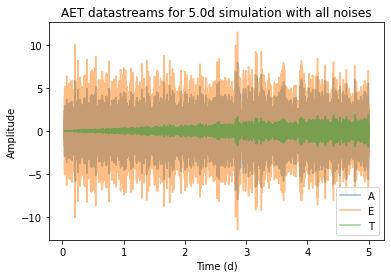

In [99]:
for i in range(3):
    plt.plot(sdata[0]/day,sdata[i+1],label=rec[i],alpha=.5)
plt.title('AET datastreams for '+str(duration/day)+'d simulation with all noises')
plt.legend(loc=4)
plt.xlabel('Time (d)')
plt.ylabel('Amplitude')
plt.show()

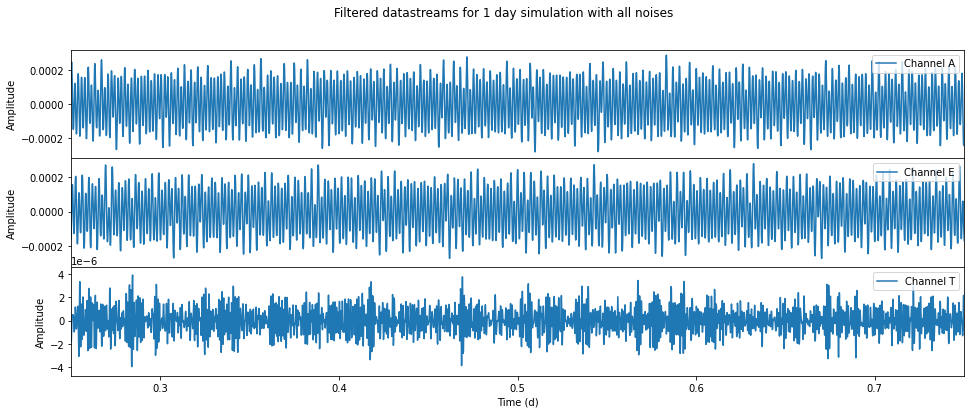

In [112]:
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Create psd for data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,1e-2,2e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,4):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1],tmp[2]])

# Create psd for filtered data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

fig, axs = plt.subplots(3, figsize=(16,6), sharex=True, gridspec_kw={'hspace':0})
fig.suptitle("Filtered datastreams for 1 day simulation with all noises")
for i in range(3):
    axs[i].plot(fsdata[0]/day,fsdata[i+1],label='Channel '+rec[i])
    axs[i].legend(loc=1)
    axs[i].set_ylabel('Amplitude')
axs[i].set_xlabel('Time (d)')
axs[i].set_xlim(.25,.75)
plt.show()

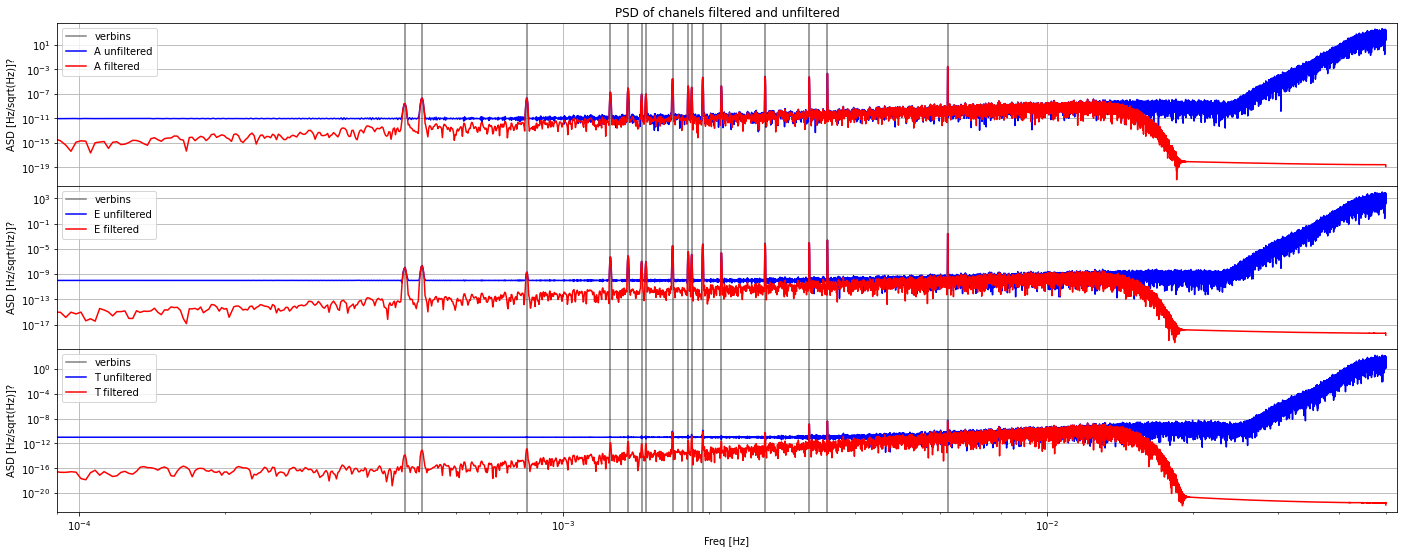

In [132]:
fig, axs = plt.subplots(3, figsize=(24,9), sharex=True, gridspec_kw={'hspace':0})
for i in range(3):
    for f in f_true:
        if f == f_true[0]:
            axs[i].plot([f]*2,[1e-50,1e50],c='black',alpha=0.5,label="verbins")
        else:
            axs[i].plot([f]*2,[1e-50,1e50],c='black',alpha=0.5)
    axs[i].plot(psd[0],psd[i+1], label=rec[i]+' unfiltered',c='blue')
    axs[i].plot(fpsd[0],fpsd[i+1], label=rec[i]+' filtered',c='red')
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Freq [Hz]')
    axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
    axs[i].set_ylim(ymin=0.1*np.min(fpsd[i+1]),ymax=10*np.max(psd[i+1]))
    # axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
    axs[i].grid()
axs[0].set_title("PSD of chanels filtered and unfiltered")
axs[i].set_xlim(xmin=9e-5,xmax=fs/1.9)#,xmax=1e-2)
plt.show()

In [102]:
# Difference factor between pytdi.Data.from_instrument and pytdi.Data.from_gws

def dphi_to_dnu(fs,data):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt = 1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.diff(data) * ((laser_freq) / (2*np.pi*dt))

# Building The Galactic Binary MCMC fit
Here is a list of things that can be done to speed up the model simulation function:
1) Stop exporting and importing GalBin data and simulated data, but directly input them in functions
2) Improve the AET calculation times & simulation setup times (takes 4s)
3) Decrease sampling rate of LISA instrument
4) 

In [103]:
# Generate random binary to be able to build the TDI chanels
time_elapsed = []
time_elapsed.append(time.time())

if os.path.exists('gws_tmp.h5'):
    os.remove('gws_tmp.h5')

for a, f, p, beta, lamb in zip(Amp_true, f_true, phi0_true, gw_beta_true, gw_lambda_true):
    GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=orbits_t0+10, gw_beta=beta, gw_lambda=lamb, dt=1/fs, size=size+300)
    # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
    GalBin.write('gw_tmp.h5')

print ("Gws generated")
    
time_elapsed.append(time.time()) 
rawdata = Data.from_gws('gw_tmp.h5',orbit_path,interpolate=True)#, skipped=-int(size))
time_elapsed.append(time.time())

print ("Start TDI building")

Afunc = ortho.A2.build(**rawdata.args)
print ("A chanel built")
Efunc = ortho.E2.build(**rawdata.args)
print ("E chanel built")
time_elapsed.append(time.time())
A = Afunc(rawdata.measurements)[discard:]
E = Efunc(rawdata.measurements)[discard:]
print ("A calculated")
time_elapsed.append(time.time())

tmp = np.array(time_elapsed)[1:] - np.array(time_elapsed[:-1])
print ("gw_gen = {:.3f}, signal_gen = {:.3f}, TDIbuild = {:.3f}, TDIcalc = {:.3f}, Total = {:.3f}".format(*tmp,time_elapsed[-1]-time_elapsed[0]))

t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]
mdata = np.array([t,A,E])

os.remove('gw_tmp.h5')


# Without interpolate, for 30 days it takes 7s, with interpolate it takes 0.66s
#but it takes 1.8s to generate the GW's as apposed to 0.68s

Gws generated
Start TDI building
A chanel built
E chanel built
A calculated
gw_gen = 1.771, signal_gen = 0.227, TDIbuild = 8.123, TDIcalc = 0.272, Total = 10.394


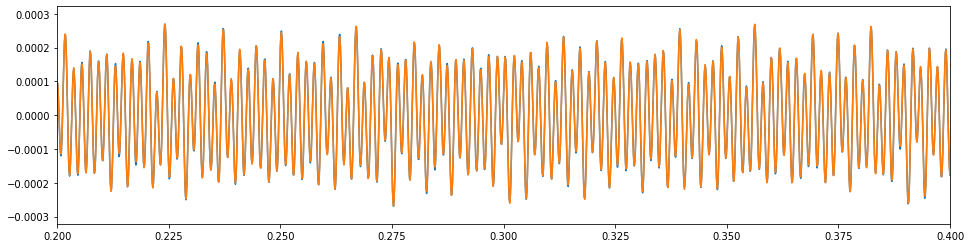

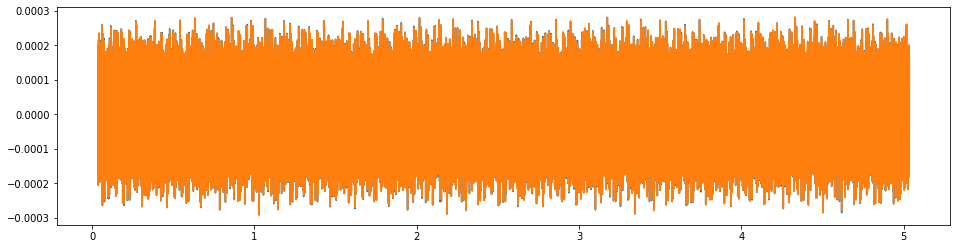

In [104]:
plt.figure(figsize=(16,4))
plt.plot(fsdata[0]/day,fsdata[1])
plt.plot(t[:-1]/day,dphi_to_dnu(fs,A))
plt.xlim(0.2,0.4)
plt.show()
plt.figure(figsize=(16,4))
plt.plot(fsdata[0]/day,fsdata[2])
plt.plot(t[:-1]/day,dphi_to_dnu(fs,E))
# plt.xlim(0.2,0.25)
plt.show()

# MCMC on the data

In [105]:
# Defining the model used for MCMC fitting

def model(st, orbits_ZP=0,Amp=Amp_true, phi0=phi0_true, freq=f_true, gw_beta=gw_beta_true, gw_lambda=gw_lambda_true, t0=orbits_t0+10):
    
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    
    
    # Amp, phi0 = theta[0:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
    # Generate GW signals
    for a, f, p, beta, lamb in zip(Amp, freq, phi0, gw_beta, gw_lambda):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta-orbits_ZP, gw_lambda=lamb, dt=1/fs, size=size+300)
        # Amplitude is a/f since we have to convert from_gws to from_instr by differentiating and don't want extra factors of 2pi*f
        GalBin.write(gwfn)
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    os.remove(gwfn)
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]

    return np.array([nnmt,nnmA,nnmE])
    # return np.array([t,A,E,T])

Time elapsed = 2.82
(4, 42700)
(3, 42700)


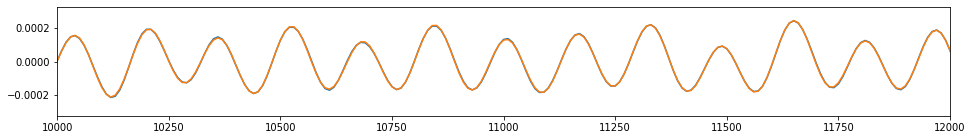

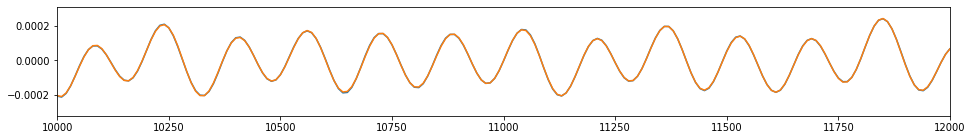

In [106]:
# Testing if model works and plotting 

script_time0 = time.time()

mdata = model(fsdata[0])

script_time1 = time.time() - script_time0
print ("Time elapsed = {:.2f}".format(script_time1))

for i in [1,2]:
    plt.figure(figsize=(16,2))
    plt.plot(fsdata[0],fsdata[i])
    plt.plot(test[0],test[i])
    plt.xlim(1e4,1.2e4)
    plt.plot()
print (fsdata.shape)
print (test.shape)

In [107]:
# Define functions needed for mcmc fitting
import emcee
from tqdm import tqdm

# Guesses
Amp_guess, f_guess, phi0_guess = Amp_true*np.random.rand(Ngalbins), f_true, phi0_true
#phi0_guess = phi0_true #rad
#theta_guess = np.array([Amp_guess, f_guess])

theta_guess = np.array([Amp_guess,f_guess,phi0_guess])
theta_true = np.array([Amp_true,f_true,phi0_true])


# Coding gaussian prior
def gauss_prior(arr, sig, mu):
    gauss = np.exp(-((arr-mu)**2)/(2*(sig**2)))
    return np.log(gauss)#/(np.sqrt(2*np.pi*(sig)**2))) so gaussian is not normalised so peak is at 1 (log peak at 0)

# Setting up the priors is [observed quantity, error in quantity]
Amp_prior = Amp_guess*np.array([[1]*Ngalbins,[0.01]*Ngalbins])

# # Plotting amplitude and frequency prior to see if all went well
# for i, xlab in zip(range(4),["Amplitude","Frequency [Hz]"]):
#     x = [np.linspace(1e-18,1e-16,1000),np.linspace(5e-4,5e-3,1000)]
#     plt.plot(x[i],gauss_prior(x[i],obs_q[i]*obs_qe[i],obs_q[i]))
#     plt.plot([x[i][0],x[i][-1]],[0,0],c='black',linestyle='dashed')
#     plt.xlabel(xlab)
#     plt.show()

def lnL(theta, t, y1, y2):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    # Amp, f, phi0 = theta
    # beta_ZP, Amp = theta[0], theta[1:]
    # Amp_lnL, phi0_lnL = theta[:Ngalbins], theta[Ngalbins:2*Ngalbins]
    beta_ZP_lnL = np.copy(theta)
    
    # newt, y1_model, y2_model = model(t, Amp_lnL,phi0_lnL)
    newt, y1_model, y2_model = model(t, beta_ZP_lnL)
    
    return 0.5*(np.sum((y1-y1_model)**2)) + 0.5*(np.sum((y2-y2_model)**2))

def lnprior(theta):
    """
    Define a gaussian prior that preferences values near the observed values of the Galactic binaries     
    """
    # Amp, phi0 = theta[:Ngalbins], theta[Ngalbins:2*Ngalbins]
    
    # beta_ZP, Amp = theta[0], theta[1:]
    # Amp_lnprior, phi0_lnprior = theta[:Ngalbins], theta[Ngalbins:2*Ngalbins]
    beta_ZP_lnprior = np.copy(theta)
    
    # if (int(np.sum((1e-26 < Amp)*(Amp<1e-20))) == Ngalbins):# and -np.pi <= beta_ZP <= np.pi:
    # if (int(np.sum((1e-26 < Amp_lnprior)*(Amp_lnprior<1e-20))) == Ngalbins) and int(np.sum((-np.pi <= phi0_lnprior)* (phi0_lnprior<= np.pi))) == Ngalbins:
    if -np.pi <= beta_ZP_lnprior <= np.pi:
        return 0
    return np.inf
    
    # if 1e-18 < Amp < 1e-14:
    #     return gauss_prior(f, obs_q[1]*obs_qe[1],obs_q[1])
    # return -np.inf
    # if int(np.sum((-np.pi <= phi0) * (phi0 <= np.pi))) == Ngalbins:
    #     return np.sum(gauss_prior(Amp,Amp_prior[1],Amp_prior[0])) #gauss_prior(Amp, obs_q[0]*obs_qe[0], obs_q[0]) + gauss_prior(f, obs_q[1]*obs_qe[1],obs_q[1])
    # return -np.inf
    
def lnprob(theta, t, y1, y2):
    """
    The likelihood to include in the MCMC.
    """
    # global iters
    # iters +=1
    
    lp = lnprior(theta)
    if not np.isfinite(lp):
        # print (iters,'infty')
        return np.inf
    lnlikely = lp + lnL(theta,t,y1, y2)
    # print (iters,lnlikely)
    return lnlikely


In [133]:
# Calculate likelyhoods for range of zeropoints in the orbit

t0 = time.time()
zp_range = np.pi*np.linspace(-1,1,51)
zp_range2 = np.linspace(-0.25,0.25,51)
L_zp_range = np.zeros(len(zp_range))
L_zp_range2 = np.zeros(len(zp_range2))
for i in range(len(zp_range)):
    L_zp_range[i] = lnprob([zp_range[i]],fsdata[0],fsdata[1], fsdata[2])
for i in range(len(zp_range2)):
    L_zp_range2[i] = lnprob([zp_range2[i]],fsdata[0],fsdata[1], fsdata[2])
    
print ("Time elapsed = {} s".format(time.time()-t0))

Time elapsed = 262.9521737098694 s


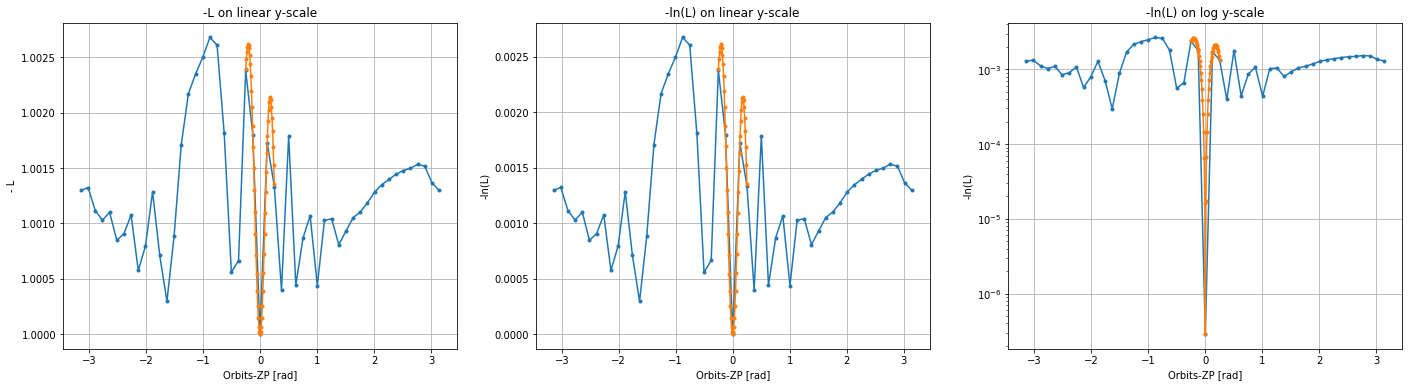

In [134]:
# Plot likelyhoods for range of zeropoints in the orbit

def L_zp_plot(zp_rnge,L_rnge):
    # fig, axs = plt.subplots(1,3, figsize=(24,6))
    # fig.title("test")

    axs[0].set_title("-L on linear y-scale")
    axs[0].plot(zp_rnge,np.exp(L_rnge),marker='.')
    axs[0].set_ylabel("- L")
    axs[1].set_title("-ln(L) on linear y-scale")
    axs[2].set_title("-ln(L) on log y-scale")
    axs[2].set_yscale('log')
    for i in range(1,3):
        axs[i].set_ylabel("-ln(L)")
        axs[i].plot(zp_rnge,L_rnge,marker='.')
    for i in range(3):
        axs[i].set_xlabel("Orbits-ZP [rad]")
        axs[i].grid()

fig, axs = plt.subplots(1,3, figsize=(24,6))
L_zp_plot(zp_range,L_zp_range)
L_zp_plot(zp_range2,L_zp_range2)
for i in range(3):
    axs[i].grid()
plt.show()


In [135]:
def parabula_err(x0, xpm):
    """Finds error of likelyhood parabula. Input must be the optimal value and the offset from this for which to calculate the parabula. The output is sigma"""
    f0 = lnprob([x0],fsdata[0],fsdata[1], fsdata[2])
    fp, fm = lnprob([x0+xpm],fsdata[0],fsdata[1], fsdata[2]),lnprob([x0-xpm],fsdata[0],fsdata[1], fsdata[2])
    
    # print (f0,fp,fm, np.mean([fp,fm]))
    return xpm/np.sqrt(((fp+fm)/2) - f0)

def parabula(x0, sig, xpm=0.1):
    A = lnprob([x0],fsdata[0],fsdata[1], fsdata[2])
    xrange = 1*xpm*np.linspace(-1,1,200)
    return np.array([xrange, (A + (((xrange-x0)**2)/(sig**2)))])

Sigma = 2.464


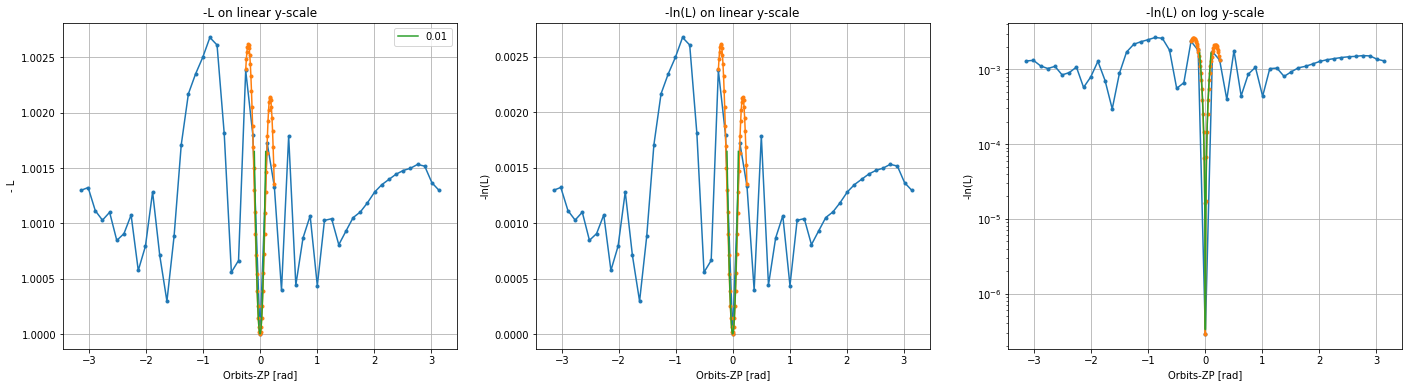

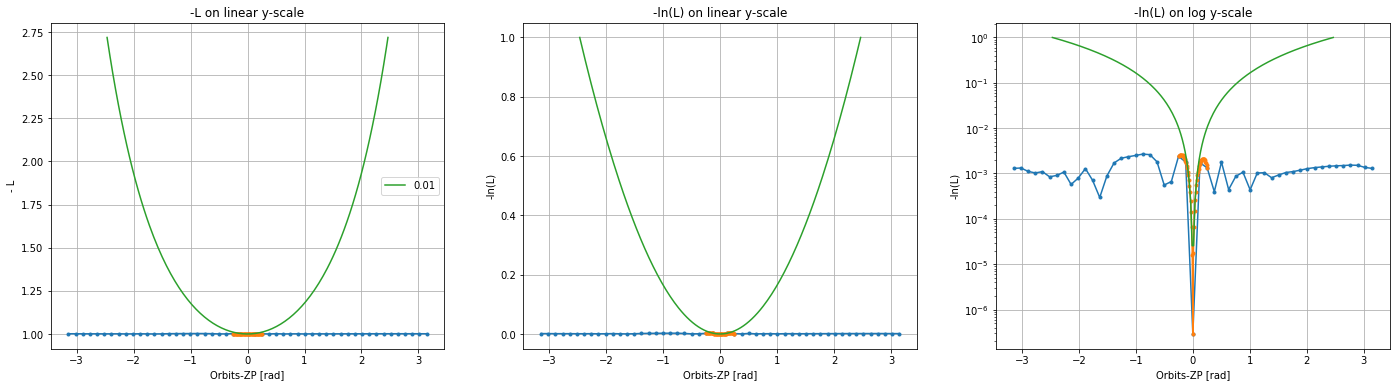

In [137]:
sigma = parabula_err(0,.01)
print ("Sigma = {:.3f}".format(sigma))

fig, axs = plt.subplots(1,3, figsize=(24,6))
L_zp_plot(zp_range,L_zp_range)
L_zp_plot(zp_range2,L_zp_range2)
x,y = parabula(0,sigma,0.1)
axs[0].plot(x,np.exp(y),label='0.01')
axs[0].legend()
for j in range(1,3):
    axs[j].plot(x,y)
for i in range(3):
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(24,6))
L_zp_plot(zp_range,L_zp_range)
L_zp_plot(zp_range2,L_zp_range2)
x,y = parabula(0,sigma,sigma)
axs[0].plot(x,np.exp(y),label='0.01')
axs[0].legend()
for j in range(1,3):
    axs[j].plot(x,y)
for i in range(3):
    axs[i].grid()
plt.show()

In [47]:

N = 25
xpms = np.logspace(-3,-1,N)
sigmas = np.zeros(N)
print (xpms)
for i in range(len(xpms)):
    sigmas[i] = parabula_err(0,xpms[i])

print (xpms)
print (sigmas)

[0.001      0.00121153 0.0014678  0.00177828 0.00215443 0.00261016
 0.00316228 0.00383119 0.00464159 0.00562341 0.00681292 0.00825404
 0.01       0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1       ]
[0.001      0.00121153 0.0014678  0.00177828 0.00215443 0.00261016
 0.00316228 0.00383119 0.00464159 0.00562341 0.00681292 0.00825404
 0.01       0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1       ]
[247.25352017 247.25491279 247.25695431 247.25995214 247.26435182
 247.27081074 247.28029094 247.29420705 247.31463504 247.34462325
 247.38864851 247.45328755 247.54820496 247.68761153 247.89241971
 248.19344114 248.63615266 249.28784969 250.24849015 251.66736518
 253.76923433 256.89640839 261.57897252 268.65752327 279.51063173]


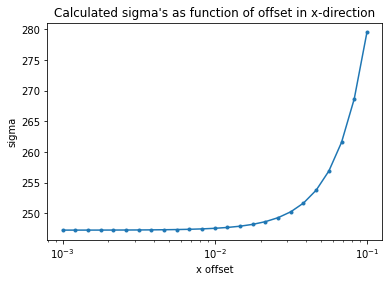

In [48]:
plt.semilogx(xpms,sigmas,marker='.')
plt.xlabel("x offset")
plt.ylabel("sigma")
plt.title("Calculated sigma's as function of offset in x-direction")
plt.show()

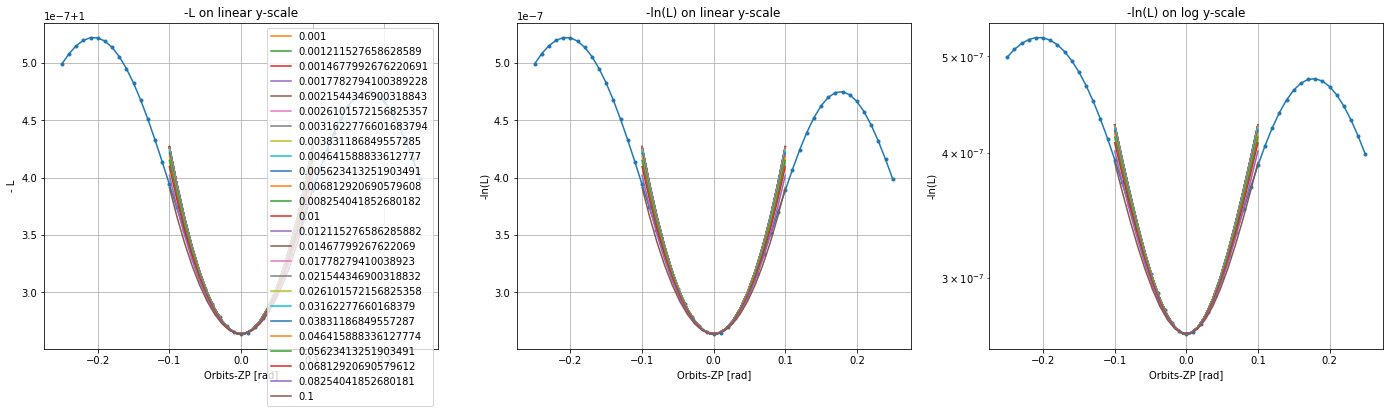

In [32]:

fig, axs = plt.subplots(1,3, figsize=(24,6))
L_zp_plot(zp_range,L_zp_range)

for i in range(len(sigmas)):
    x,y = parabula(0,sigmas[i])
    axs[0].plot(x,np.exp(y),label=str(xpms[i]))
    axs[0].legend()
    for j in range(1,3):
        axs[j].plot(x,y)
plt.show()



In [ ]:
def model2(st, orbits_ZP=0,Amp=Amp_true, phi0=phi0_true, freq=f_true, gw_beta=gw_beta_true, gw_lambda=gw_lambda_true, t0=orbits_t0+10):
    # Create random filename to allow for multiprocessing
    gwfn = 'gws_spam/gwtmp_'+str(int(1e20*np.random.rand(1)[0]))+'.h5'
    # Generate GW signals
    for a, f, p, beta, lamb in zip(Amp, freq, phi0, gw_beta, gw_lambda):
        GalBin = GalacticBinary(A=a/f, f=f, phi0=p, orbits=orbit_path, t0=t0, gw_beta=beta-orbits_ZP, gw_lambda=lamb, dt=1/fs, size=int(cutoff2*fs*day)+300)
        GalBin.write(gwfn)
    rawdata = Data.from_gws(gwfn, orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    mE = Efunc(rawdata.measurements)[discard:]
    mt = GalBin.t[discard:]
    os.remove(gwfn)
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(fs,mA)
    nmE = dphi_to_dnu(fs,mE)
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA, nnmE = nmt[time_indices], nmA[time_indices], nmE[time_indices]
    return np.array([nnmt,nnmA,nnmE])

In [ ]:
cutoff2_lst = np.array(1,5,10,30)
cutoff2 = 30
for i in range(len(cutoff2_lst)):
    global cutoff2
    cutoff2 = np.copy(cutoff2_lst[i])
    
    newt, y1_model, y2_model = model(t, beta_ZP_lnL)
    
    return 0.5*(np.sum((y1-y1_model)**2)) + 0.5*(np.sum((y2-y2_model)**2))
    

In [ ]:
stop

# Find minimum of -ln(Likelyhood)

In [ ]:
# Fitting using scipy minimize and the nelder-mead technique
from scipy.optimize import minimize

iters = 0

# print (lnprob(np.array([*Amp_true,*[0,-1.5]]), fsdata[0],fsdata[1],fsdata[2]))
res_minimum = minimize(lnprob,[0],args=(fsdata[0],fsdata[1],fsdata[2]),method='Nelder-Mead',options={'disp':True,'maxiter':200})


res_localmin = minimize(lnprob,[-1.5],args=(fsdata[0],fsdata[1],fsdata[2]),method='Nelder-Mead',options={'disp':True,'maxiter':200})

In [ ]:
print (res.x)
print (res.x/np.array([*Amp_true,*phi0_true]))
print (Amp_guess/Amp_true)
test = model(fsdata[0],(res.x)[:Ngalbins],(res.x)[Ngalbins:2*Ngalbins])

for i in [1,2]:
    plt.figure(figsize=(16,2))
    plt.plot(fsdata[0],fsdata[i])
    plt.plot(test[0],test[i])
    # plt.xlim(1e4,1.1e4)
    plt.plot()